# Trabalho de Conclusão de Curso - TCC
### Turma - DSA T212
### Aluno : Drausio Gomes dos Santos
### Orientadora: Gabrielle Maria Romeiro Lombardi
### Tema: Construção e uso de modelos de grafos para representação e análise da estrutura organizacional da administração pública federal.
## Resultados Preliminares

### Etapa 8: Análise de correspondencia simples : Tipo de Ato , Se Asssinado

In [9]:
!pip install pyforest
!pip install dplython
!pip install plotnine
!pip install statstests
!pip install prince

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [113]:
import time
import datetime as dt
from datetime import datetime
import pickle
import igraph as ig
from igraph import *
print("igraph : ",ig.__version__)
import pandas as pd
import pytz
import numpy as np

from pyforest import * #Principais Libs utilizadas no python (pandas, numpy,seaborn, matplotlib ...)
from plotnine import * #Utilização das principais funcionalidades do ggplot2 nativo do R no python
from dplython import * #Utilizado das principais funcionalidades do pacote nativo do R, dplyr no Python
from scipy.stats import norm #Criações de distribuições normais
from scipy.stats.distributions import chi2 #Cálculo do teste estátistico qui2
from sklearn.preprocessing import PowerTransformer #Transformações de box-cox 

import statsmodels.api as sm #Utilização de teste Anova
import statsmodels.stats.diagnostic as dgn
import statsmodels.stats.stattools as stt
import statstests.tests as statt
import statsmodels.formula.api as smf #Criação de modelos de regressão linear/não linear
import warnings #Retirar warnings de bibliotecas auxiliares
warnings.filterwarnings('ignore')

import prince

from scipy import stats
from scipy.special import boxcox, inv_boxcox
from scipy.stats import chi2_contingency as chi2_cont

class Main:     
    def show_current_time(self):
        tz_SP = pytz.timezone('America/Sao_Paulo') 
        now = datetime.now(tz_SP)
        current_time = now.strftime("%d/%m/%Y %H:%M:%S")
        print("Current Time =", current_time)
        return now

main = Main()
    


igraph :  0.10.1


In [228]:
anos = [2019,2020,2021,2022]
base_path = "C:/projetos/tcc_dsa_usp_esalq/"
dfs = []
for ano in anos:
    anoRef = str(ano)
    data_frame_orig = pd.read_csv(base_path + "dados/dou/" + anoRef + "/" + anoRef +".csv")    
    dfs.append(data_frame_orig)

    
def lista_em_maisucula(lista):
    lista_upper =[]
    for i in lista:
        lista_upper.append(i.upper())
    return lista_upper

df = pd.concat(dfs, ignore_index=True)
df["entidades"] = df["emissor"].str.split("/")
df["unidade_emissora"] = df["entidades"].apply(lambda x:x[len(x)-1])
df.insert(2,"unidade_superior", df["entidades"].apply(lambda x:x[0]))
df['tipo'] = df['tipo'].astype('category')
df['se_ato_assinado'] = df['responsavel'].notnull()
df['se_possui_cargo'] = df['cargo'].notnull()
# colocar unidades em maisucula para evitar duplicidade de vértices
df['emissor'] = df['emissor'].apply(lambda x: x.upper())
df['unidade_superior'] = df['unidade_superior'].apply(lambda x: x.upper())
df['responsavel'] = df['responsavel'].apply(lambda x: str(x).upper())
df['cargo'] = df['cargo'].apply(lambda x: str(x).upper().replace("-"," ").replace("   "," ").replace("  "," "))
df['entidades'] = df['entidades'].apply(lambda x: lista_em_maisucula(x))
df['unidade_emissora'] = df['unidade_emissora'].apply(lambda x: x.upper())
df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,id,tipo,unidade_superior,emissor,data,responsavel,cargo,entidades,unidade_emissora,se_ato_assinado,se_possui_cargo
0,S01012019/1020_20190112_991201162-2,Decreto numerado,ATOS DO PODER JUDICIÁRIO,ATOS DO PODER JUDICIÁRIO,12/01/2019,NAN,NAN,[ATOS DO PODER JUDICIÁRIO],ATOS DO PODER JUDICIÁRIO,False,False
1,S01012019/1020_20190116_11391945,Lei,ATOS DO PODER LEGISLATIVO,ATOS DO PODER LEGISLATIVO,16/01/2019,JAIR MESSIAS BOLSONARO,NAN,[ATOS DO PODER LEGISLATIVO],ATOS DO PODER LEGISLATIVO,True,False
2,S01012019/515_20190102_11303736,Alvará,MINISTÉRIO DA SEGURANÇA PÚBLICA,MINISTÉRIO DA SEGURANÇA PÚBLICA/DEPARTAMENTO D...,02/01/2019,ROSILENE GLEICE DUARTE SANTIAGO,NAN,"[MINISTÉRIO DA SEGURANÇA PÚBLICA, DEPARTAMENTO...",COORDENAÇÃO-GERAL DE CONTROLE DE SERVIÇOS E PR...,True,False
3,S01012019/515_20190102_11303780,Alvará,MINISTÉRIO DA SEGURANÇA PÚBLICA,MINISTÉRIO DA SEGURANÇA PÚBLICA/DEPARTAMENTO D...,02/01/2019,ROSILENE GLEICE DUARTE SANTIAGO,NAN,"[MINISTÉRIO DA SEGURANÇA PÚBLICA, DEPARTAMENTO...",COORDENAÇÃO-GERAL DE CONTROLE DE SERVIÇOS E PR...,True,False
4,S01012019/515_20190102_11303801,Portaria,"MINISTÉRIO DA CIÊNCIA, TECNOLOGIA, INOVAÇÕES E...","MINISTÉRIO DA CIÊNCIA, TECNOLOGIA, INOVAÇÕES E...",02/01/2019,VILMA DE FÁTIMA ALVARENGA FANIS,NAN,"[MINISTÉRIO DA CIÊNCIA, TECNOLOGIA, INOVAÇÕES ...",COORDENAÇÃO-GERAL DE RADIODIFUSÃO COMUNITÁRIA,True,False
...,...,...,...,...,...,...,...,...,...,...,...
3233679,S03112022/609_20221130_20116254,Aviso de Suspensão,MINISTÉRIO DA DEFESA,MINISTÉRIO DA DEFESA/COMANDO DA MARINHA/EMPRES...,30/11/2022,NAIR CARLA FROMENT TEIXEIRA,PREGOEIRA,"[MINISTÉRIO DA DEFESA, COMANDO DA MARINHA, EMP...",EMPRESA GERENCIAL DE PROJETOS NAVAIS,True,True
3233680,S03112022/609_20221130_20116255,Resultado de Julgamento,MINISTÉRIO DA ECONOMIA,MINISTÉRIO DA ECONOMIA/EMPRESA DE TECNOLOGIA E...,30/11/2022,MARIO HENRIQUE BERNARDO DA SILVA,PREGOEIRO,"[MINISTÉRIO DA ECONOMIA, EMPRESA DE TECNOLOGIA...",EMPRESA DE TECNOLOGIA E INFORMAÇÕES DA PREVIDÊ...,True,True
3233681,S03112022/609_20221130_20116333,Extrato de Termo Aditivo,MINISTÉRIO DAS COMUNICAÇÕES,MINISTÉRIO DAS COMUNICAÇÕES/EMPRESA BRASILEIRA...,30/11/2022,NAN,NAN,"[MINISTÉRIO DAS COMUNICAÇÕES, EMPRESA BRASILEI...",SUPERINTENDÊNCIA ESTADUAL N3 BSB,False,False
3233682,S03112022/609_20221130_20116336,Extrato de Contrato,MINISTÉRIO DAS COMUNICAÇÕES,MINISTÉRIO DAS COMUNICAÇÕES/EMPRESA BRASILEIRA...,30/11/2022,NAN,NAN,"[MINISTÉRIO DAS COMUNICAÇÕES, EMPRESA BRASILEI...",SUPERINTENDÊNCIA ESTADUAL N1 MG,False,False


In [242]:
pd.options.display.max_rows = 999
df_agg = df.groupby(['tipo','se_ato_assinado']).agg({'se_ato_assinado':sum})
df_agg

<IPython.core.display.Javascript object>

se_ato_assinado
tipo                                               se_ato_assinado                 
Acordo Coletivo de Trabalho                        False                          0
                                                   True                          24
Acórdão                                            False                          0
                                                   True                        4051
Agenda Regulatória                                 False                          0
                                                   True                          13
Ajuste                                             False                          0
                                                   True                          16
Alvará                                             False                          0
                                                   True                        4682
Aresto                                             False                          0
                                                   True                          83
Ata                                                False                          0
                                                   True                        4782
Ata Suplementar                                    False                          0
                                                   True                           5
Ato                                                False                          0
                                                   True                       55210
Ato Complementar                                   False                          0
                                                   True                          32
Ato Concessório                                    False                          0
                                                   True                        2310
Ato Declaratório                                   False                          0
                                                   True                       12775
Ato Declaratório Conjunto                          False                          0
                                                   True                          13
Ato Normativo                                      False                          0
                                                   True                        1095
Ato Regimental                                     False                          0
                                                   True                          21
Ato Regulamentar                                   False                          0
                                                   True                          55
Auto de Infração                                   False                          0
                                                   True                          29
Autorização                                        False                          0
                                                   True                        3552
Aviso                                              False                          0
                                                   True                      201735
Aviso aos Acionistas                               False                          0
                                                   True                         258
Aviso de Adiamento                                 False                          0
                                                   True                       12830
Aviso de Adjudicação                               False                          0
                                                   True                        7801
Aviso de Alienação                                 False                          0
                                                   True                         296
Aviso de Alteração                  

In [262]:
df_agg1 = df.groupby(['emissor'])['emissor'].unique().count()
df_agg1

29239

In [280]:
pd.options.display.max_rows = 99999
df_agg1 = df.groupby(['tipo','emissor']).count()
df_agg1 

<IPython.core.display.Javascript object>

id  \
tipo                        emissor                                                  
Acordo Coletivo de Trabalho ATOS DO CONGRESSO NACIONAL                           0   
                            ATOS DO PODER EXECUTIVO                              0   
                            ATOS DO PODER JUDICIÁRIO                             0   
                            ATOS DO PODER JUDICIÁRIO/SUPREMO TRIBUNAL FEDERAL    0   
                            ATOS DO PODER JUDICIÁRIO/SUPREMO TRIBUNAL FEDER...   0   
...                                                                             ..   
autorização de acesso       TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...   0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...   0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...   0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...   0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...   0   

                                                                                unidade_superior  \
tipo                        emissor                                                                
Acordo Coletivo de Trabalho ATOS DO CONGRESSO NACIONAL                                         0   
                            ATOS DO PODER EXECUTIVO                                            0   
                            ATOS DO PODER JUDICIÁRIO                                           0   
                            ATOS DO PODER JUDICIÁRIO/SUPREMO TRIBUNAL FEDERAL                  0   
                            ATOS DO PODER JUDICIÁRIO/SUPREMO TRIBUNAL FEDER...                 0   
...                                                                                          ...   
autorização de acesso       TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...                 0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...                 0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...                 0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...                 0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...                 0   

                                                                                data  \
tipo                        emissor                                                    
Acordo Coletivo de Trabalho ATOS DO CONGRESSO NACIONAL                             0   
                            ATOS DO PODER EXECUTIVO                                0   
                            ATOS DO PODER JUDICIÁRIO                               0   
                            ATOS DO PODER JUDICIÁRIO/SUPREMO TRIBUNAL FEDERAL      0   
                            ATOS DO PODER JUDICIÁRIO/SUPREMO TRIBUNAL FEDER...     0   
...                                                                              ...   
autorização de acesso       TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...     0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...     0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...     0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...     0   
                            TRIBUNAL DE CONTAS DA UNIÃO/SECRETARIA-GERAL DE...     0   

                                                                                responsavel  \
tipo                        emissor                                                           
Acordo Coletivo de Trabalho ATOS DO CONGRESSO NACIONAL                                    0   
                            ATOS DO PODER EXECUTIVO                                       0   
                            ATOS DO PODER JUDICIÁRIO                                      0   
                            ATOS DO PODE

In [244]:
import math
contingencia = pd.crosstab(df['tipo'], df['se_ato_assinado'], margins = True)
#contingencia.drop(['All'], axis = 1, inplace = True)
#contingencia.drop(['All'], axis = 0, inplace = True)
contingencia

<IPython.core.display.Javascript object>

se_ato_assinado,False,True,All
tipo,,,
Acordo Coletivo de Trabalho,65,24,89
Acórdão,177,4051,4228
Agenda Regulatória,3,13,16
Ajuste,56,16,72
Alvará,3,4682,4685
Aresto,2,83,85
Ata,15266,4782,20048
Ata Suplementar,0,5,5
Ato,6390,55210,61600


In [230]:
chi2, p, dof, expect = chi2_cont(contingencia)
print(f'chi2 = {chi2:.2f} e p-valor = {p:}')
expect

chi2 = 2582078.51 e p-valor = 0.0


array([[3.44021635e+01, 5.55978087e+01, 2.78320245e-05],
       [1.61613719e+03, 2.61186150e+03, 1.30748666e-03],
       [6.11594017e+00, 9.88405488e+00, 4.94791546e-06],
       [2.75217308e+01, 4.44782470e+01, 2.22656196e-05],
       [1.79082373e+03, 2.89417482e+03, 1.44881150e-03],
       [3.24909322e+01, 5.25090415e+01, 2.62858009e-05],
       [7.66327304e+03, 1.23847208e+04, 6.19973807e-03],
       [1.91123130e+00, 3.08876715e+00, 1.54622358e-06],
       [2.35463697e+04, 3.80536113e+04, 1.90494745e-02],
       [1.91123130e+01, 3.08876715e+01, 1.54622358e-05],
       [9.22360227e+02, 1.49063903e+03, 7.46207500e-04],
       [5.09190244e+03, 8.22909344e+03, 4.11944886e-03],
       [4.96920139e+00, 8.03079459e+00, 4.02018131e-06],
       [5.90188227e+02, 9.53811296e+02, 4.77473842e-04],
       [9.93840278e+00, 1.60615892e+01, 8.04036262e-06],
       [2.29347757e+01, 3.70652058e+01, 1.85546830e-05],
       [1.14673878e+01, 1.85326029e+01, 9.27734149e-06],
       [1.42807203e+03, 2.30792

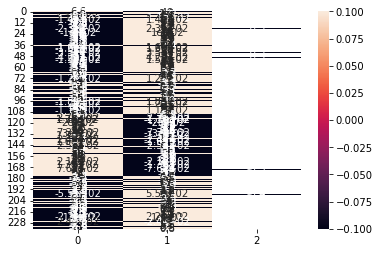

In [231]:
n = np.matrix(contingencia, dtype = float)
cont_sum_row = n.sum(axis=1)
cont_sum_col = n.sum(axis=0)
freq_abs_esperada = (np.multiply(cont_sum_row,
                                 cont_sum_col))/n.sum()
freq_abs_esperada = np.around(freq_abs_esperada, decimals = 1)
residuo = n - freq_abs_esperada
chi2 = np.divide(np.square(residuo), freq_abs_esperada).sum()
chi2 = np.round(chi2,2)
chi2
residuo_std = residuo / np.sqrt(freq_abs_esperada)
residuo_std = np.around(residuo_std, decimals = 1)

residuo_std_ajst = np.divide(residuo_std,
                       np.sqrt(np.multiply(
                           (1-(cont_sum_col/n.sum())),
                           (1-(cont_sum_row/n.sum())))))
residuo_std_ajst = np.around(residuo_std_ajst, decimals = 1)
import seaborn as sns
ax = sns.heatmap(residuo_std_ajst, annot=True)

In [232]:
import prince
cca = prince.CA(n_components=2,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42)
modelcca = cca.fit(contingencia)
modelcca.row_coordinates(contingencia)

,0,1
Acordo Coletivo de Trabalho,0.718510,19.979585
Acórdão,-0.700468,-0.000201
Agenda Regulatória,-0.400766,-0.000353
Ajuste,0.813957,-0.000969
Alvará,-0.785301,-0.000158
...,...,...
Súmula,-0.371351,-0.000368
Súmula Administrativa,-0.786619,-0.000157
Termo de Autorização,0.921070,-0.001023
Termo de Liberação de Operação,-0.786619,-0.000157


In [233]:
modelcca.column_coordinates(contingencia)

,0,1
False,1.128052,-0.000127
True,-0.698003,-0.000017
na,0.809728,189.547297


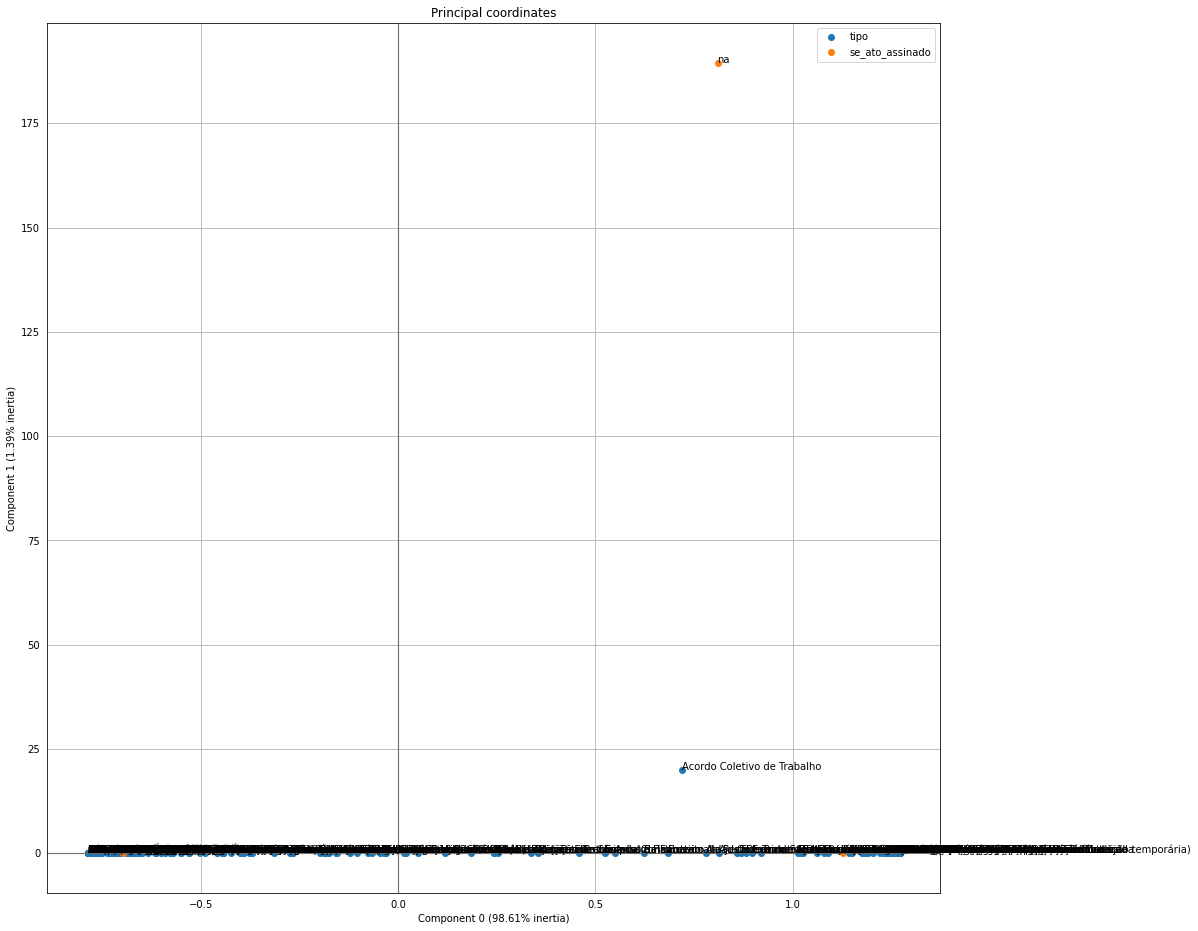

In [234]:
ax = modelcca.plot_coordinates(X = contingencia,
                         ax = None,
                         figsize = (16,16),
                         x_component = 0,
                         y_component = 1,
                         show_row_labels = True,
                         show_col_labels = True)

(235, 3)
2


<IPython.core.display.Javascript object>

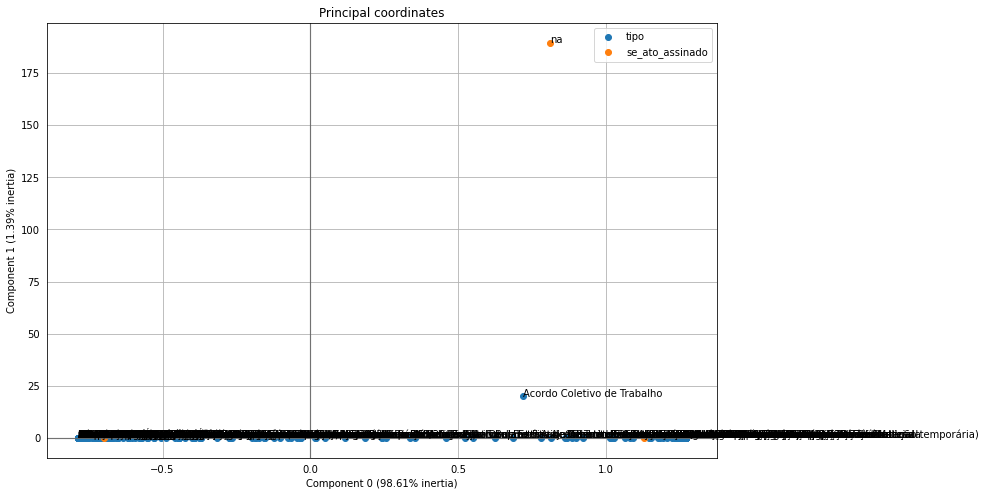

In [235]:
# Num. de dimensões
ndim = (np.array(contingencia.shape) - 1).min()
# Criando o modelo ANACOR
print(contingencia.shape)
print(ndim)
ca = prince.CA(n_components=3)
ca.fit(contingencia);
ca.plot_coordinates(contingencia, figsize=(12, 8))
plt.show()